# Réseau de neurones

## Import packages

In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.layers import Dense
import cv2 as cv
from sklearn import preprocessing
import seaborn as sns

___

## Implémentation en code python

Création de la fonction python permettant de produire différents réseaux de neurones de type perceptron multicouches.

Pour la création du model, elle se fait couche par couche. Nous avons un modèle de type perceptron multi-couches avec :
- une couche d'entrée
- deux couches cachées de 128 neurones avec des activations (ReLU par défaut, mais peut être modifié)
- une couche de sortie de 10 neurones avec activation Softmax car en sortie nous avons un label, plusieurs classes

Puis nous avons configuré la méthode d'entrainement de ce modèle en prenant en compte plusieurs critères :
- optimizer : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié)
- loss : la fonction objectif que l'on souhaite minimiser (ici categorical_crossentropy)
- metrics : la métrique considée pour évaluer les performances (ici accuracy)
Puis, on peut entraîner le modèle en précisant la façon dont les données seront présentées lors de l'entrainement :
- epochs : un passage sur l'ensemble des données de la base d'entrainement (par défaut 20, mais peut être modifié)
- batch_size : définit le nombre d'exemples qui seront propagés à chaque itération pour calculer la mise à jour des poids (par défaut 128, mais peut être modifié)

Ensuite, on ajuste le modèle : on l'entraîne sur nos données dans train. Où :
- epochs : nombre de fois qu'il faut itérer sur les tableaux de données
- batch_size : nombre d'échantillons par mise à jour du gradient
- callbacks : objet qui peut effectuer des actions à différentes étapes de la formation
    - soit vide
    - soit qui a été crée par nous même avec callbacks.EarlyStopping :
        - monitor : quantité à surveiller (ici les pertes "loss")
        - mode : mode (ici "min")
        - patience : nombre d'époch sans amélioration après lesquelles l'entrainement sera arrêté (ici 4)
        - restore_best_weights : s'il faut rester les poids du modèle à partir de l'époch avec la meilleure valeur de la quantité surveillé (ici vrai)
        - verbose : mode de verbosité (ici 2 : une ligne de journal par époch)
        - validation_data : (ici x_validate et y_validate)

Pour finir, nous avons cherché à valider notre modèle. En effet, nous regardons si le modèle est le mieux adapté au problème donné et aux données correspondantes. Pour cela, nous avons besoin des données de test et leurs étiquettes. On rentre également le nombre d'exemples à propagés pour chaque itération.

In [147]:
def mlp_model(train_set, test_set, validate_set, optimizer_name='adam', nb_hidden_layer=3, nb_cellules=128, batch_size=128, learning_rate=0.001, epochs=20,
              activation_function="relu", callback_application=True):
    """
    :param callback_application : objet qui peut effectuer des actions à différentes étapes de la formation
    :param optimizer_name : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié)
    :param batch_size : nombre d'échantillons par mise à jour du gradient
    :param train_set :
    :param test_set :
    :param validate_set :
    :param learning_rate :
    :param activation_function : type de fonction d'activation
    :param epochs : nombre de fois qu'il faut itérer sur les tableaux de données
    :param nb_hidden_layer : nombre de couches cachées
    :param nb_cellules : nombre de cellules par couche cachée
    """

    model = keras.models.Sequential()
    # des couches cachées de 128 neurones avec activation ReLU par défaut
    for i in range(nb_hidden_layer):
        model.add(Dense(nb_cellules, activation=activation_function))
    # une couche de sortie de 10 neurones avec activation Softmax
    model.add(Dense(10, activation='softmax'))

    x_train = train_set[0]
    y_train = train_set[1]
    x_test = test_set[0]
    y_test = test_set[1]
    x_validate = validate_set[0]
    y_validate = validate_set[1]

    optimizer = None
    if optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if callback_application:
        es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)
        # rp = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=4, verbose=1, mode="max", min_lr=0.00001, )
        callback = [es]
    else:
        callback = []

    model_fit = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callback, verbose=2, validation_data=(x_validate, y_validate))
    model.summary()

    model_score = model.evaluate(x_test, y_test, batch_size=batch_size)

    return model, model_fit, model_score

---

## Préparation des données
Nous effectuons des pré-traitement sur les données d'entrée à travers différentes fonctions :

### Normaliser les données

In [148]:
def normalize(x):
    return x / 255

### Standardiser les données
Standardiser les données en supprimant la moyenne et en mettant à l'échelle la variance unitaire


In [149]:
def standardize(x):
    # scaler = preprocessing.StandardScaler().fit(x)
    # x_scaled = scaler.transform(x)

    mean_px = x.mean().astype(np.float32)
    std_px = x.std().astype(np.float32)
    x_scaled = (x - mean_px) / std_px

    return x_scaled

### Seuillage manuelle

Appliquer un seuillage manuelle sur une image et contient plusieurs paramètres
- image à traiter
- valeur du seuil (0.5 par défaut)
- la couleur que prendra les objets une fois seuillé (ici 1)
- type de seuilr (ici TRESH_BINARY)

In [150]:
def img_preprocessing(x, threshold=0.5):
    return cv.threshold(x, threshold, 1, cv.THRESH_BINARY)[1]

### Représentation des 25 premières images

- prépration du jeu de données pour qu'il soit conforme : donne une nouvelle "shape"
- plt.subplot : création d'une figure avec 5x5 grilles de sous-parcelles
- plt.xticks : définir les emplacements des graduations de l'axe x
- plt.yticks : définir les emplacements des graduations de l'axe y
- plt.grid : si on veut afficher les grilles (ici non)
- plt.imshow : afficher les données sous forme d'image (2D)

In [151]:
def display_img(x):
    plt.figure(figsize=(8, 8))
    x = x.reshape(len(x), 28, 28, 1)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.cm.binary)

### Préparation des nouveaux jeux de données

Appel du jeu de données mnist_all et création des jeux test, train et validate
- Récupère dans Y les données de la première colonne du jeu de données, car elles représentent les numéros qu'il faut avoir et dans X les données
- train_test_split : divise nos jeux de données en sous-ensembles d'entraînement, de test et de validation.
    - test_size permet de donner la proportion que nous voulons mettre dans d'abord test puis dans validate : 10% dans test, 10% dans validate et 80% dans train
    - On l'applique 2 fois pour séparer en 3 fois les jeux de données initiaux
- On normalise nos x (train, test, validate)
- Si on le souhaite (en l'indiquant quand on appelle la fonction) on peut appeler la fonction qui permet d'appliquer un seuil sur une image (ici sur nos x_train, x_test, x_validate)
- Convertir nos y (train, test, validate) en matrice de classe binaire
- Afficher les états de nos nouveaux jeux de données

In [152]:
def load_and_split_data():
    data = pd.read_csv("mnist_all.csv")
    x = np.array(data.iloc[:, 1:])
    y = data.iloc[:, 0]

    x_train_validate, x_test, y_train_validate, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size=0.2222, random_state=0, stratify=y_train_validate)

    # plot label for train, test , validate
    all_label = y.value_counts().sort_index(ascending=False).plot(kind='barh', title="Label distribution")
    all_label.bar_label(all_label.containers[0])

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    train_label_plot = y_train.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[0], title="Train label distribution")
    train_label_plot.bar_label(train_label_plot.containers[0])
    test_label_plot = y_test.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[1], title="Test label distribution")
    test_label_plot.bar_label(test_label_plot.containers[0])
    validate_label_plot = y_validate.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[2], title="Validation label distribution")
    validate_label_plot.bar_label(validate_label_plot.containers[0])

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]


def data_preparation(train_origin, test_origin, validate_origin, process_img=False):
    x_train = normalize(train_origin[0])
    x_test = normalize(test_origin[0])
    x_validate = normalize(validate_origin[0])

    x_train = standardize(x_train)
    x_test = standardize(x_test)
    x_validate = standardize(x_validate)

    if process_img:
        x_train = img_preprocessing(x_train)
        x_test = img_preprocessing(x_test)
        x_validate = img_preprocessing(x_validate)

    y_train = keras.utils.to_categorical(train_origin[1], 10)
    y_test = keras.utils.to_categorical(test_origin[1], 10)
    y_validate = keras.utils.to_categorical(validate_origin[1], 10)

    print('shape X train : ', x_train.shape)
    print('shape X test : ', x_test.shape)
    print('shape X validate : ', x_validate.shape)
    print('shape Y train : ', y_train.shape)
    print('shape Y test : ', y_test.shape)
    print('shape Y validate : ', y_validate.shape)

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

---

## Elaboration de l'expérimentation
Maintenant, nous allons permettre l'affichage graphique des différentes informations.


### Représentation de taux d'erreur et taux de réussite

Grâce à l'historique de model.fit (voir Implémentation en code Python) on peut récupérer plusieurs les métriques qui sont stocks dans un dictionnaire :
- accuracy
- val_accuracy
- loss
- val_loss

De ce fait, cela inclut la perte (loss) et la précision (accuracy) ainsi que la perte et la précision de l'ensemble de données de validation. Et nous pouvons créer des graphiques à partir de ces données.

On a créé un graphique de précision (accuracy) sur les ensembles de données d'entrainement et de validation sur les epochs d'entrainement.

Puis un graphique de perte (loss) sur les ensembles de données d'entrainement et de validation en cours des epochs d'entrainement.

In [153]:
def plot_model_result(model_fit):
    plt.subplot(2, 1, 1)
    plt.plot(model_fit.history['accuracy'])
    plt.plot(model_fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout()

### Confusion matrix

In [154]:
def plot_confusion_matrix(model, test):
    fig = plt.figure(figsize=(8, 8))

    y_pred = model.predict(test[0])

    Y_pred = np.argmax(y_pred, 1)
    Y_test = np.argmax(test[1], 1)

    mat = confusion_matrix(Y_test, Y_pred)

    sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    return Y_pred, Y_test

### Enregistrement des modèles

Enregistrer tous les modèles que nous avons effectué dans model_path.

In [155]:
def save_model(model, model_name):
    save_dir = "./results/"
    model_path = save_dir + model_name
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

### Affichage des erreurs

In [156]:
def display_errors(label_pred, label_test, data_test):
    label_test = np.argmax(label_test, 1)
    errors = (label_pred - label_test != 0)
    Y_pred_errors_class = label_pred[errors]  # [1, 2, 3, 5, 9, ....]
    Y_test_errors_class = label_test[errors]  # [1, 2, 3, 5, 9, ....]
    X_test_errors = data_test[errors]
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 7))
    for row in range(nrows):
        for col in range(ncols):
            error_index = np.where(Y_test_errors_class == ncols * row + col)
            if error_index:
                error_index = np.random.choice(error_index[0], size=1)
            else:
                continue
            ax[row, col].imshow((X_test_errors[error_index]).reshape((28, 28)), cmap=plt.cm.binary)
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_errors_class[error_index], Y_test_errors_class[error_index]))
            n += 1

### Load data from file

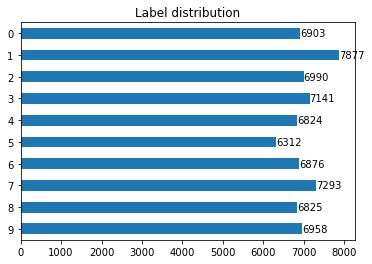

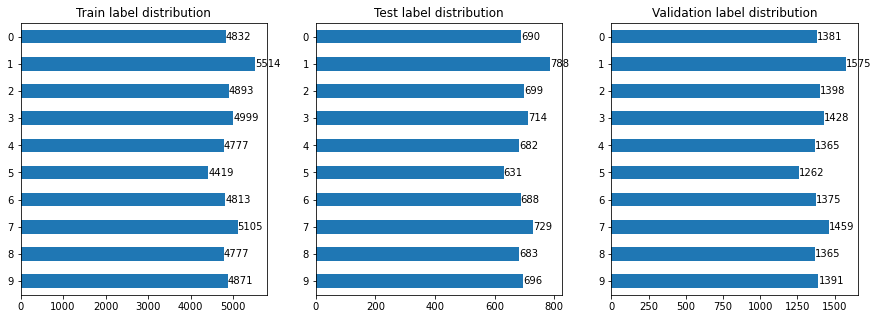

In [157]:
train_org, test_org, validate_org = load_and_split_data()
all_scores = {}

In [158]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=False)

shape X train :  (49000, 784)
shape X test :  (7000, 784)
shape X validate :  (13999, 784)
shape Y train :  (49000, 10)
shape Y test :  (7000, 10)
shape Y validate :  (13999, 10)


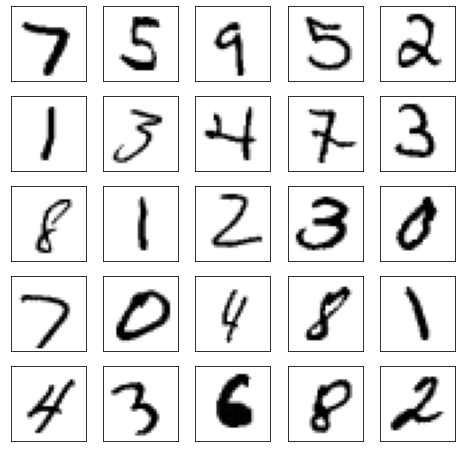

In [159]:
display_img(train[0])

### Expérimentation 1
Description de l'expérimentation 1
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [160]:
model, model_fit, score = mlp_model(train_set=train,
                                    test_set=test,
                                    validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=32,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu")
save_model(model, "model1_batchsz32")
all_scores["model1_batchsz32"] = score[1]

Epoch 1/30



KeyboardInterrupt



---

### Expérimentation 2
Description de l'expérimentation 2
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **64**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**


In [ ]:
model, model_fit, score = mlp_model(train_set=train,
                                    test_set=test,
                                    validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=64,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu")
save_model(model, "model2_batchsz64")
all_scores["model2_batchsz64"] = score[1]

### Expérimentation 3
Description de l'expérimentation 3
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **86**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**


In [ ]:
model, model_fit, score = mlp_model(train_set=train,
                                    test_set=test,
                                    validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=86,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu")
save_model(model, "model3_batchsz86")
all_scores["model3_batchsz86"] = score[1]

### Expérimentation 4
Description de l'expérimentation 4
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **128**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [ ]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=128,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model4_batchsz128")
all_scores["model4_batchsz128"] = score[1]

383/383 - 3s - loss: 0.2280 - accuracy: 0.9329 - val_loss: 0.2333 - val_accuracy: 0.9312 - 3s/epoch - 7ms/step
Epoch 5/30
383/383 - 2s - loss: 0.2031 - accuracy: 0.9407 - val_loss: 0.2151 - val_accuracy: 0.9361 - 2s/epoch - 4ms/step
Epoch 6/30
383/383 - 1s - loss: 0.1847 - accuracy: 0.9458 - val_loss: 0.2011 - val_accuracy: 0.9404 - 1s/epoch - 3ms/step
Epoch 7/30
383/383 - 1s - loss: 0.1684 - accuracy: 0.9502 - val_loss: 0.1862 - val_accuracy: 0.9449 - 1s/epoch - 3ms/step
Epoch 8/30
383/383 - 1s - loss: 0.1558 - accuracy: 0.9540 - val_loss: 0.1723 - val_accuracy: 0.9489 - 1s/epoch - 3ms/step
Epoch 9/30
383/383 - 1s - loss: 0.1447 - accuracy: 0.9573 - val_loss: 0.1648 - val_accuracy: 0.9502 - 1s/epoch - 4ms/step
Epoch 10/30
383/383 - 1s - loss: 0.1347 - accuracy: 0.9608 - val_loss: 0.1552 - val_accuracy: 0.9535 - 1s/epoch - 3ms/step
Epoch 11/30
383/383 - 1s - loss: 0.1262 - accuracy: 0.9635 - val_loss: 0.1492 - val_accuracy: 0.9573 - 1s/epoch - 3ms/step
Epoch 12/30
383/383 - 1s - loss: 

### Expérimentation 5
Description de l'expérimentation 5
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **200**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [ ]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=200,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model5_batchsz200")
all_scores["model5_batchsz200"] = score[1]

Epoch 1/30
245/245 - 2s - loss: 1.1784 - accuracy: 0.6656 - val_loss: 0.4965 - val_accuracy: 0.8646 - 2s/epoch - 6ms/step
Epoch 2/30
245/245 - 1s - loss: 0.3966 - accuracy: 0.8858 - val_loss: 0.3531 - val_accuracy: 0.8988 - 991ms/epoch - 4ms/step
Epoch 3/30
245/245 - 1s - loss: 0.3129 - accuracy: 0.9081 - val_loss: 0.3039 - val_accuracy: 0.9104 - 962ms/epoch - 4ms/step
Epoch 4/30
245/245 - 1s - loss: 0.2726 - accuracy: 0.9201 - val_loss: 0.2742 - val_accuracy: 0.9200 - 1s/epoch - 4ms/step
Epoch 5/30
245/245 - 1s - loss: 0.2455 - accuracy: 0.9283 - val_loss: 0.2514 - val_accuracy: 0.9252 - 1s/epoch - 4ms/step
Epoch 6/30
245/245 - 1s - loss: 0.2250 - accuracy: 0.9343 - val_loss: 0.2335 - val_accuracy: 0.9295 - 987ms/epoch - 4ms/step
Epoch 7/30
245/245 - 1s - loss: 0.2081 - accuracy: 0.9397 - val_loss: 0.2177 - val_accuracy: 0.9347 - 1s/epoch - 6ms/step
Epoch 8/30
245/245 - 2s - loss: 0.1940 - accuracy: 0.9433 - val_loss: 0.2089 - val_accuracy: 0.9368 - 2s/epoch - 8ms/step
Epoch 9/30
245/

### Expérimentation 6
Description de l'expérimentation 5
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [ ]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="adam",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=32,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model6_adam")
all_scores["model6_adam"] = score[1]

Epoch 1/30
1532/1532 - 5s - loss: 0.2320 - accuracy: 0.9286 - val_loss: 0.1616 - val_accuracy: 0.9499 - 5s/epoch - 3ms/step
Epoch 2/30
1532/1532 - 4s - loss: 0.1114 - accuracy: 0.9653 - val_loss: 0.1482 - val_accuracy: 0.9564 - 4s/epoch - 3ms/step
Epoch 3/30
1532/1532 - 4s - loss: 0.0852 - accuracy: 0.9723 - val_loss: 0.1052 - val_accuracy: 0.9680 - 4s/epoch - 3ms/step
Epoch 4/30
1532/1532 - 4s - loss: 0.0644 - accuracy: 0.9795 - val_loss: 0.1385 - val_accuracy: 0.9621 - 4s/epoch - 3ms/step
Epoch 5/30
1532/1532 - 4s - loss: 0.0559 - accuracy: 0.9821 - val_loss: 0.0940 - val_accuracy: 0.9748 - 4s/epoch - 3ms/step
Epoch 6/30
1532/1532 - 4s - loss: 0.0494 - accuracy: 0.9834 - val_loss: 0.1110 - val_accuracy: 0.9720 - 4s/epoch - 3ms/step
Epoch 7/30
1532/1532 - 4s - loss: 0.0421 - accuracy: 0.9864 - val_loss: 0.1073 - val_accuracy: 0.9691 - 4s/epoch - 3ms/step
Epoch 8/30
1532/1532 - 4s - loss: 0.0405 - accuracy: 0.9873 - val_loss: 0.1074 - val_accuracy: 0.9731 - 4s/epoch - 3ms/step
Epoch 9/

In [ ]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=True)

shape X train :  (49000, 784)
shape X test :  (7000, 784)
shape X validate :  (13999, 784)
shape Y train :  (49000, 10)
shape Y test :  (7000, 10)
shape Y validate :  (13999, 10)


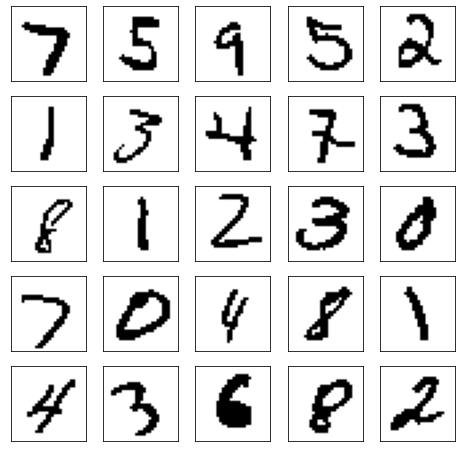

In [ ]:
display_img(train[0])

### Expérimentation 7
Description de l'expérimentation 7
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **[binary threshold](https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html)**
* activation function: **relu**
* callback : **EarlyStopping**

In [ ]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=32,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model7_imgprc")
all_scores["model7_imgprc"] = score[1]

Epoch 1/30
1532/1532 - 6s - loss: 0.7243 - accuracy: 0.7989 - val_loss: 0.3439 - val_accuracy: 0.8993 - 6s/epoch - 4ms/step
Epoch 2/30
1532/1532 - 5s - loss: 0.2917 - accuracy: 0.9143 - val_loss: 0.2729 - val_accuracy: 0.9210 - 5s/epoch - 3ms/step
Epoch 3/30
1532/1532 - 5s - loss: 0.2323 - accuracy: 0.9311 - val_loss: 0.2368 - val_accuracy: 0.9285 - 5s/epoch - 3ms/step
Epoch 4/30
1532/1532 - 5s - loss: 0.1944 - accuracy: 0.9430 - val_loss: 0.2050 - val_accuracy: 0.9394 - 5s/epoch - 3ms/step
Epoch 5/30
1532/1532 - 6s - loss: 0.1672 - accuracy: 0.9507 - val_loss: 0.1753 - val_accuracy: 0.9475 - 6s/epoch - 4ms/step
Epoch 6/30
1532/1532 - 5s - loss: 0.1459 - accuracy: 0.9571 - val_loss: 0.1658 - val_accuracy: 0.9499 - 5s/epoch - 3ms/step
Epoch 7/30
1532/1532 - 5s - loss: 0.1305 - accuracy: 0.9611 - val_loss: 0.1569 - val_accuracy: 0.9514 - 5s/epoch - 3ms/step
Epoch 8/30
1532/1532 - 4s - loss: 0.1169 - accuracy: 0.9657 - val_loss: 0.1448 - val_accuracy: 0.9566 - 4s/epoch - 3ms/step
Epoch 9/

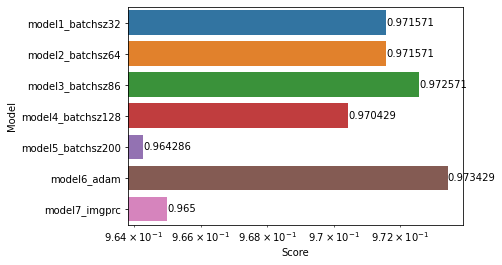

In [ ]:
x = list(all_scores.keys())
y = list(all_scores.values())
scores_df = pd.DataFrame({'Model': x, 'Score': y})

ax = sns.barplot(x='Score', y='Model', data=scores_df)
ax.set_xscale("log")
ax.bar_label(ax.containers[0])
plt.show()

azeazez

In [ ]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=False)

shape X train :  (49000, 784)
shape X test :  (7000, 784)
shape X validate :  (13999, 784)
shape Y train :  (49000, 10)
shape Y test :  (7000, 10)
shape Y validate :  (13999, 10)


In [ ]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate, optimizer_name="sgd", nb_hidden_layer=3, nb_cellules=128, batch_size=32,
                                    learning_rate=0.001, epochs=30, activation_function="relu")

Epoch 1/30
1532/1532 - 5s - loss: 0.4546 - accuracy: 0.8654 - val_loss: 0.2402 - val_accuracy: 0.9310 - 5s/epoch - 3ms/step
Epoch 2/30
1532/1532 - 4s - loss: 0.1910 - accuracy: 0.9439 - val_loss: 0.1708 - val_accuracy: 0.9489 - 4s/epoch - 3ms/step
Epoch 3/30
1532/1532 - 5s - loss: 0.1401 - accuracy: 0.9582 - val_loss: 0.1428 - val_accuracy: 0.9584 - 5s/epoch - 3ms/step
Epoch 4/30
1532/1532 - 4s - loss: 0.1113 - accuracy: 0.9667 - val_loss: 0.1262 - val_accuracy: 0.9615 - 4s/epoch - 3ms/step
Epoch 5/30
1532/1532 - 4s - loss: 0.0913 - accuracy: 0.9729 - val_loss: 0.1119 - val_accuracy: 0.9666 - 4s/epoch - 3ms/step
Epoch 6/30
1532/1532 - 4s - loss: 0.0767 - accuracy: 0.9781 - val_loss: 0.1028 - val_accuracy: 0.9695 - 4s/epoch - 3ms/step
Epoch 7/30
1532/1532 - 4s - loss: 0.0661 - accuracy: 0.9802 - val_loss: 0.0989 - val_accuracy: 0.9707 - 4s/epoch - 3ms/step
Epoch 8/30
1532/1532 - 4s - loss: 0.0568 - accuracy: 0.9835 - val_loss: 0.0985 - val_accuracy: 0.9716 - 4s/epoch - 3ms/step
Epoch 9/

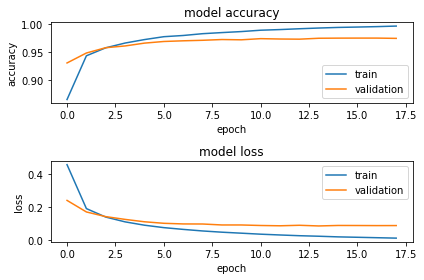

In [ ]:
plot_model_result(model_fit)

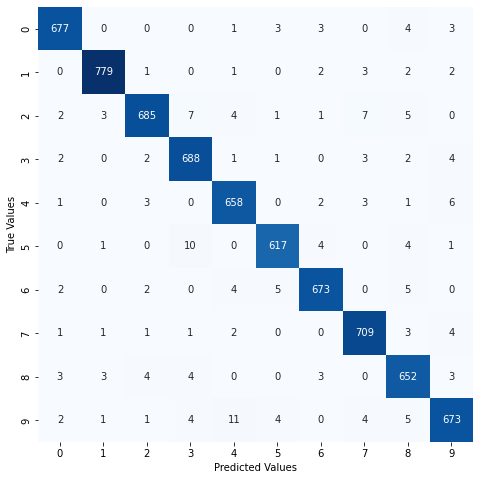

In [ ]:
Y_pred, Y_test = plot_confusion_matrix(model, test)

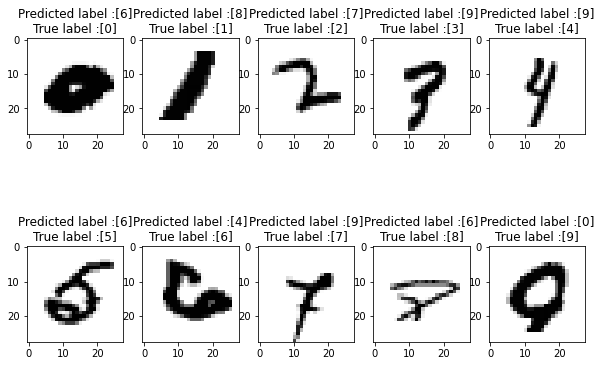

In [ ]:
display_errors(Y_pred, test[1], test[0])